In [165]:
# without dataframe
import numpy as np
import math
from itertools import product
from scipy.sparse import diags
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# M1/m2 Mac上での警告回避
from tensorflow.compat.v1.keras.optimizers import Adam as LegacyAdam

tf.config.run_functions_eagerly(True) # eager executionを有効に
tf.data.experimental.enable_debug_mode() # なんか警告でたのでデバッグモードを有効に


In [166]:
# params
# energy
x_max = 9 # xの最大値
x_step = 1  # 刻み幅を指定
x_list = np.arange(0, x_max + x_step, x_step)
M2 = 1 # EFTのcutoff scale
m2_list = M2 * (1 + x_list) 
m2_step = M2 * x_step
# spin
J_max = 40 # Jの最大値
J_list = np.arange(0, J_max, 2) # Jの値域
# spacetime dimension
d = 10

In [167]:
# m2_list

In [168]:
# input data
X_input = np.array(list(product(J_list, m2_list)), dtype=np.float64)

In [169]:
# g_k関数, null constraint, 各係数

# m2^{(2-d)/2} heavy averageの係数
def m2coeff(J, m2):
    return ( m2**((2-d)/2) )

def mathcalJ2(J):
    return J * (J + d - 3)

def g2(J, m2):
    return 1 / (m2 ** 2)

def g3(J, m2):
    return ( 3 - (4/(d-2)) * mathcalJ2(J) ) / ( m2 ** 3 )

def n4(J, m2):
    return ( mathcalJ2(J) * ( 2*mathcalJ2(J)- 5*d + 4 ) ) / ( m2 ** 4 )

In [170]:
# 各関数の行列を作成
# def diagonalize(func):
#     diagonal_values = func(X_input[:, 0], X_input[:, 1])
#     # sparse_matrix = tf.sparse.from_dense(diagonal_values)
#     # return sparse_matrix

#     tensor_matrix = tf.cast(tf.convert_to_tensor(diagonal_values), dtype=tf.double)
#     return tensor_matrix

# m2coeff_vector = diagonalize(m2coeff)
# g2_vector = diagonalize(g2)
# g3_matrix = diagonalize(g3)
# n4_matrix = diagonalize(n4)


In [171]:
# 各関数のvectorを作成
def make_vector(func):
    vector = tf.convert_to_tensor(func(X_input[:, 0], X_input[:, 1]), dtype=tf.double)
    vector = tf.expand_dims(vector, axis=1)
    return vector

m2coeff_vector = make_vector(m2coeff)
g2_vector = make_vector(g2)
g3_vector = make_vector(g3)
n4_vector = make_vector(n4)


In [172]:
# heavy average
# 積分
def approx_integral(func_vector, rho_vector):
    integrand = m2coeff_vector * ( func_vector * rho_vector )
    # 1がm2_max個ならんだ小ブロックを作成
    block = np.ones(len(m2_list))
    # ブロック対角行列を作成
    integral_matrix = np.kron(np.eye(len(J_list)), block)

    return (1/m2_step) * tf.matmul( integral_matrix, integrand )

In [173]:
# normalization constant
def nJd(J):
    return ( (4*np.pi)**(d/2) * (d+2*J-3) * (np.vectorize(math.gamma)(d+J-3)) ) / ( np.pi * np.vectorize(math.gamma)((d-2)/2)*np.vectorize(math.gamma)(J+1) )
# 総和
def heavy_average(func_vector, rho_vector):
    return tf. reduce_sum( nJd(J=J_list) * approx_integral(func_vector, rho_vector) )

In [174]:
# model
n_node = 4
model = Sequential([
    Dense(n_node, activation='relu', input_dim=2, dtype=tf.double),
    Dense(1, activation='relu', dtype=tf.double)
])

In [175]:
# loss function
def custom_loss(y_true, y_pred):
        a2 = 1 
        a3 = 1
        w4 = 1
        
        rho_vecotor = model(X_input)

        g2_term = a2 * heavy_average(func_vector=g2_vector, rho_vector=rho_vecotor)
        g3_term = a3 * heavy_average(func_vector=g3_vector, rho_vector=rho_vecotor)
        n4_term =  w4 * tf.abs(heavy_average(func_vector=n4_vector, rho_vector=rho_vecotor))
        loss =  g2_term + g3_term + n4_term
        # loss =  g2_term + g3_term
        return loss

In [176]:
# compile
model.compile(optimizer=LegacyAdam(), loss=custom_loss)

In [177]:
initial_factor = 15
y_input = initial_factor * tf.ones(len(X_input), dtype=np.float64)
# y_input = tf.zeros(len(X_input), dtype=np.float64)

In [178]:
# 学習
n_epochs = 60
for i in range(1, n_epochs+1): # 反復回数
    history = model.fit(X_input, y_input, epochs=n_epochs, verbose=0)
    if i % (2) == 0:
        print(f'{i}th epoch')
        print(f'loss: {history.history["loss"]}')

2th epoch
loss: [1623083039326208.0, 1623082905108480.0, 1623082770890752.0, 1623082770890752.0, 1623082636673024.0, 1623082234019840.0, 1623082234019840.0, 1623082099802112.0, 1623081831366656.0, 1623081831366656.0, 1623081697148928.0, 1623081562931200.0, 1623081160278016.0, 1623081160278016.0, 1623081026060288.0, 1623080891842560.0, 1623080623407104.0, 1623080623407104.0, 1623080489189376.0, 1623080220753920.0, 1623079952318464.0, 1623079952318464.0, 1623079818100736.0, 1623079683883008.0, 1623079415447552.0, 1623079147012096.0, 1623079147012096.0, 1623078744358912.0, 1623078610141184.0, 1623078475923456.0, 1623078341705728.0, 1623078073270272.0, 1623077939052544.0, 1623077804834816.0, 1623077536399360.0, 1623077402181632.0, 1623077267963904.0, 1623076865310720.0, 1623076865310720.0, 1623076731092992.0, 1623076596875264.0, 1623076328439808.0, 1623076194222080.0, 1623075925786624.0, 1623075657351168.0, 1623075523133440.0, 1623075388915712.0, 1623075120480256.0, 1623074852044800.0, 162

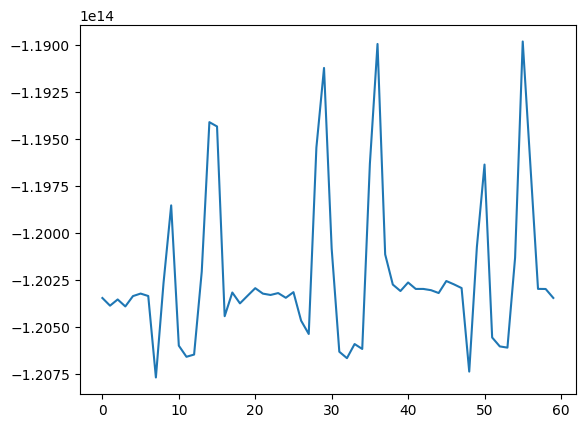

In [179]:
# 学習曲線
plt.plot(history.history['loss'])

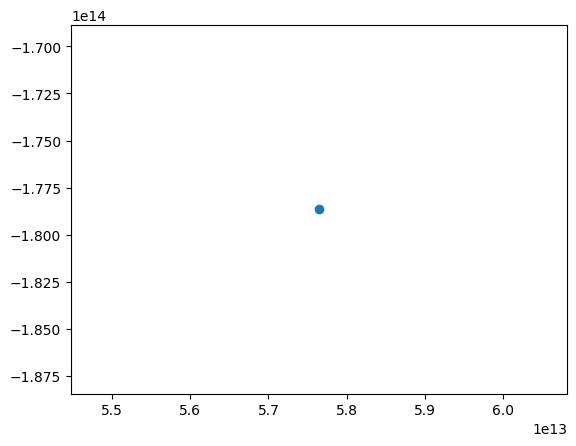

In [183]:
# 結果の描画
x = heavy_average(func_vector=g2_vector, rho_vector=model(X_input)).numpy()
y = heavy_average(func_vector=g3_vector, rho_vector=model(X_input)).numpy()
plt.plot(x,y, 'o', label='data')